In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## PCA

### Custom

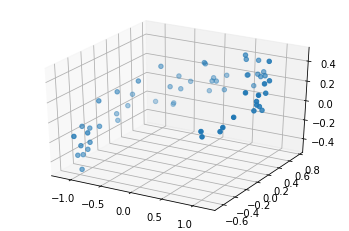

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

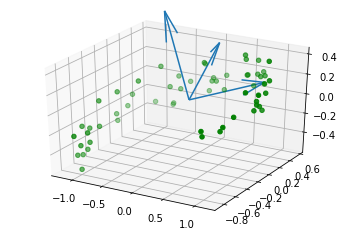

In [42]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
vectors = Vt.T # Unitary vector that composes the plane

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_centered[:, 0], X_centered[:, 1], X_centered[:, 2], c='green')
ax.quiver(0, 0, 0, *vectors[:, 0])
ax.quiver(0, 0, 0, *vectors[:, 1])
ax.quiver(0, 0, 0, *vectors[:, 2])

plt.show()

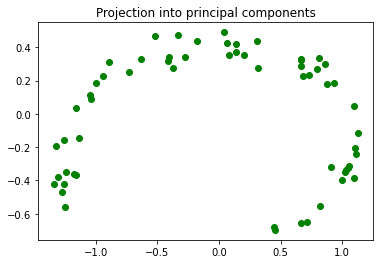

In [46]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

plt.title('Projection into principal components')
plt.scatter(X2D[:, 0], X2D[:, 1], c='green')
plt.show()

### Sci-kit learn

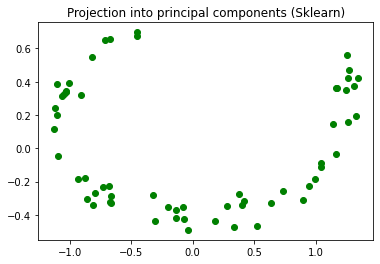

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

plt.title('Projection into principal components (Sklearn)')
plt.scatter(X2D[:, 0], X2D[:, 1], c='green')
plt.show()

In [54]:
pca.explained_variance_ratio_ # First principal component has most of variance

array([0.84248607, 0.14631839])

### Experiment: Mnist PCA

In [64]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [65]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

PCA(svd_solver='full') uses svd way

PCA(svd_solver='randoized') uses random way

PCA(svd_solver='auto') Selects automatically depending computing complexity

In [74]:
pca = PCA(n_components=0.95) # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_.shape # Reduced to 153 dimensions

(153,)

In [75]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary', **options)
    plt.axis("off")

In [76]:
X_recovered = pca.inverse_transform(X_train_pca)

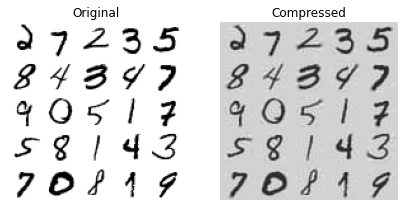

In [77]:
plt.figure(figsize=(7, 4))

plt.subplot(121)
plt.title('Original')
plot_digits(X_train[::2100])

plt.subplot(122)
plt.title('Compressed')
plot_digits(X_recovered[::2100])

plt.show()

## IncrementalPCA

In [80]:
from sklearn.decomposition import IncrementalPCA

inc_pca = IncrementalPCA(n_components=154)
n_batches = 100

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
# Or could do just .fit() once if array is in memory or is a numpy buffer (np.memmap)

X_reduced = inc_pca.transform(X_train)

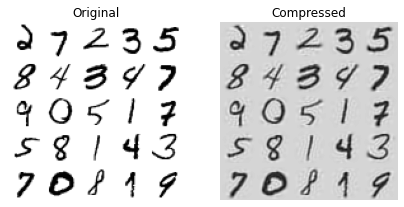

In [81]:
X_recovered = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))

plt.subplot(121)
plt.title('Original')
plot_digits(X_train[::2100])

plt.subplot(122)
plt.title('Compressed')
plot_digits(X_recovered[::2100])

plt.show()

## Kernel PCA

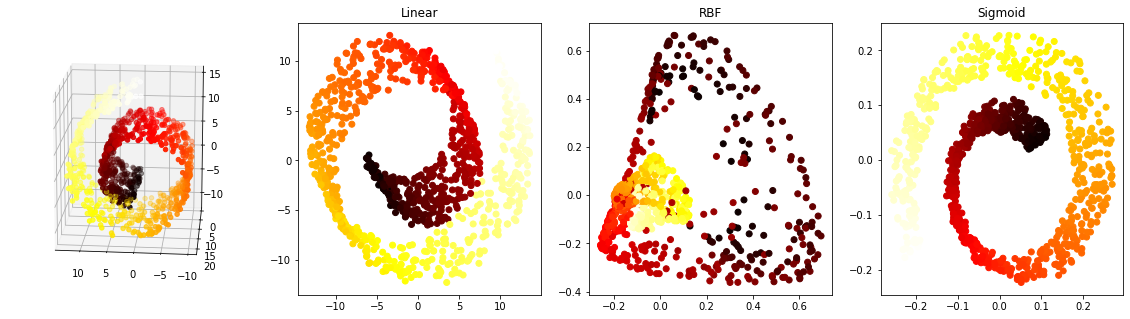

In [104]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141, projection='3d')
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components = 2, kernel="linear")
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1)

for subplot, pca, title in [(142, lin_pca, 'Linear'), (143, rbf_pca, 'RBF'), (144, sig_pca, 'Sigmoid')]:
    plt.subplot(subplot)
    plt.title(title)
    X_reduced = pca.fit_transform(X)

    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='hot')
ax.view_init(15,95)
plt.show()

### Grid Search (tuning)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

y = t > 6.9

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = {
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X, y)

In [110]:
grid_search.best_params_, grid_search.best_score_

({'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'},
 0.9320038601475726)

## LLE (Locally Linear Embedding)

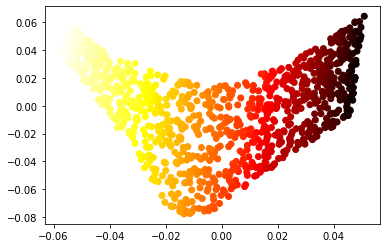

In [114]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')

## Exercises

### Time comparison

In [15]:
import time
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(mnist['data'], mnist['target'], random_state=42, train_size=60000)


In [18]:
rnd_clf = RandomForestClassifier(n_estimators=100)

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

y_pred = rnd_clf.predict(X_test)
print('Time', t1 - t0)
print('Accuracy', accuracy_score(y_test, y_pred))

Time 51.00490403175354
Accuracy 0.968


In [19]:
pca = PCA(n_components=0.95)

X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
rnd_pca_clf = RandomForestClassifier(n_estimators=100)

t0 = time.time()
rnd_pca_clf.fit(X_train_transformed, y_train)
t1 = time.time()

y_pred = rnd_pca_clf.predict(X_test_transformed)
print('Time:', t1 - t0)
print('Accuracy:', accuracy_score(y_test, y_pred))

Time: 118.81778740882874
Accuracy: 0.9468


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

log_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, multi_class='multinomial'))
])

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

y_pred = log_clf.predict(X_test)
print('Time:', t1 - t0)
print('Accuracy:', accuracy_score(y_test, y_pred))

Time: 32.77675986289978
Accuracy: 0.9163


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [25]:
pca_log_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, multi_class='multinomial'))
])

t0 = time.time()
pca_log_clf.fit(X_train_transformed, y_train)
t1 = time.time()

y_pred = pca_log_clf.predict(X_test_transformed)
print('Time:', t1 - t0)
print('Accuracy:', accuracy_score(y_test, y_pred))

Time: 10.959250688552856
Accuracy: 0.918


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Mnist Plots

In [28]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(mnist.data.shape[0])[:m]

X = mnist.data[idx]
y = mnist.target[idx]

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

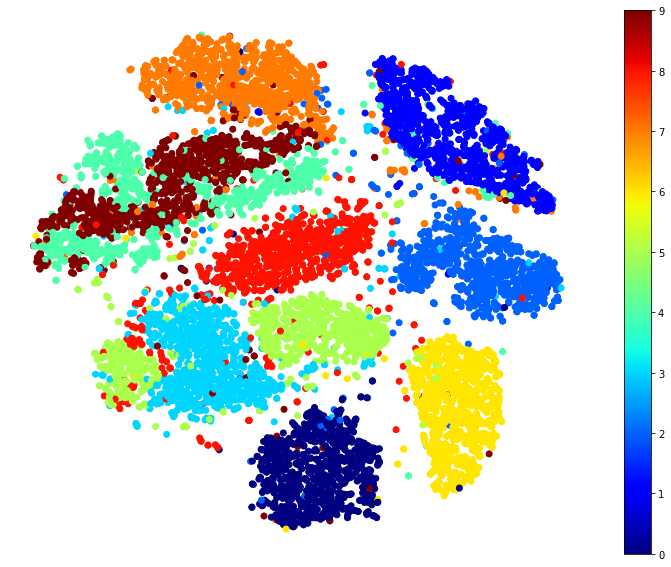

In [40]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

In [73]:

from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance >= min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

plot_digits(X_reduced, y)

SyntaxError: ignored

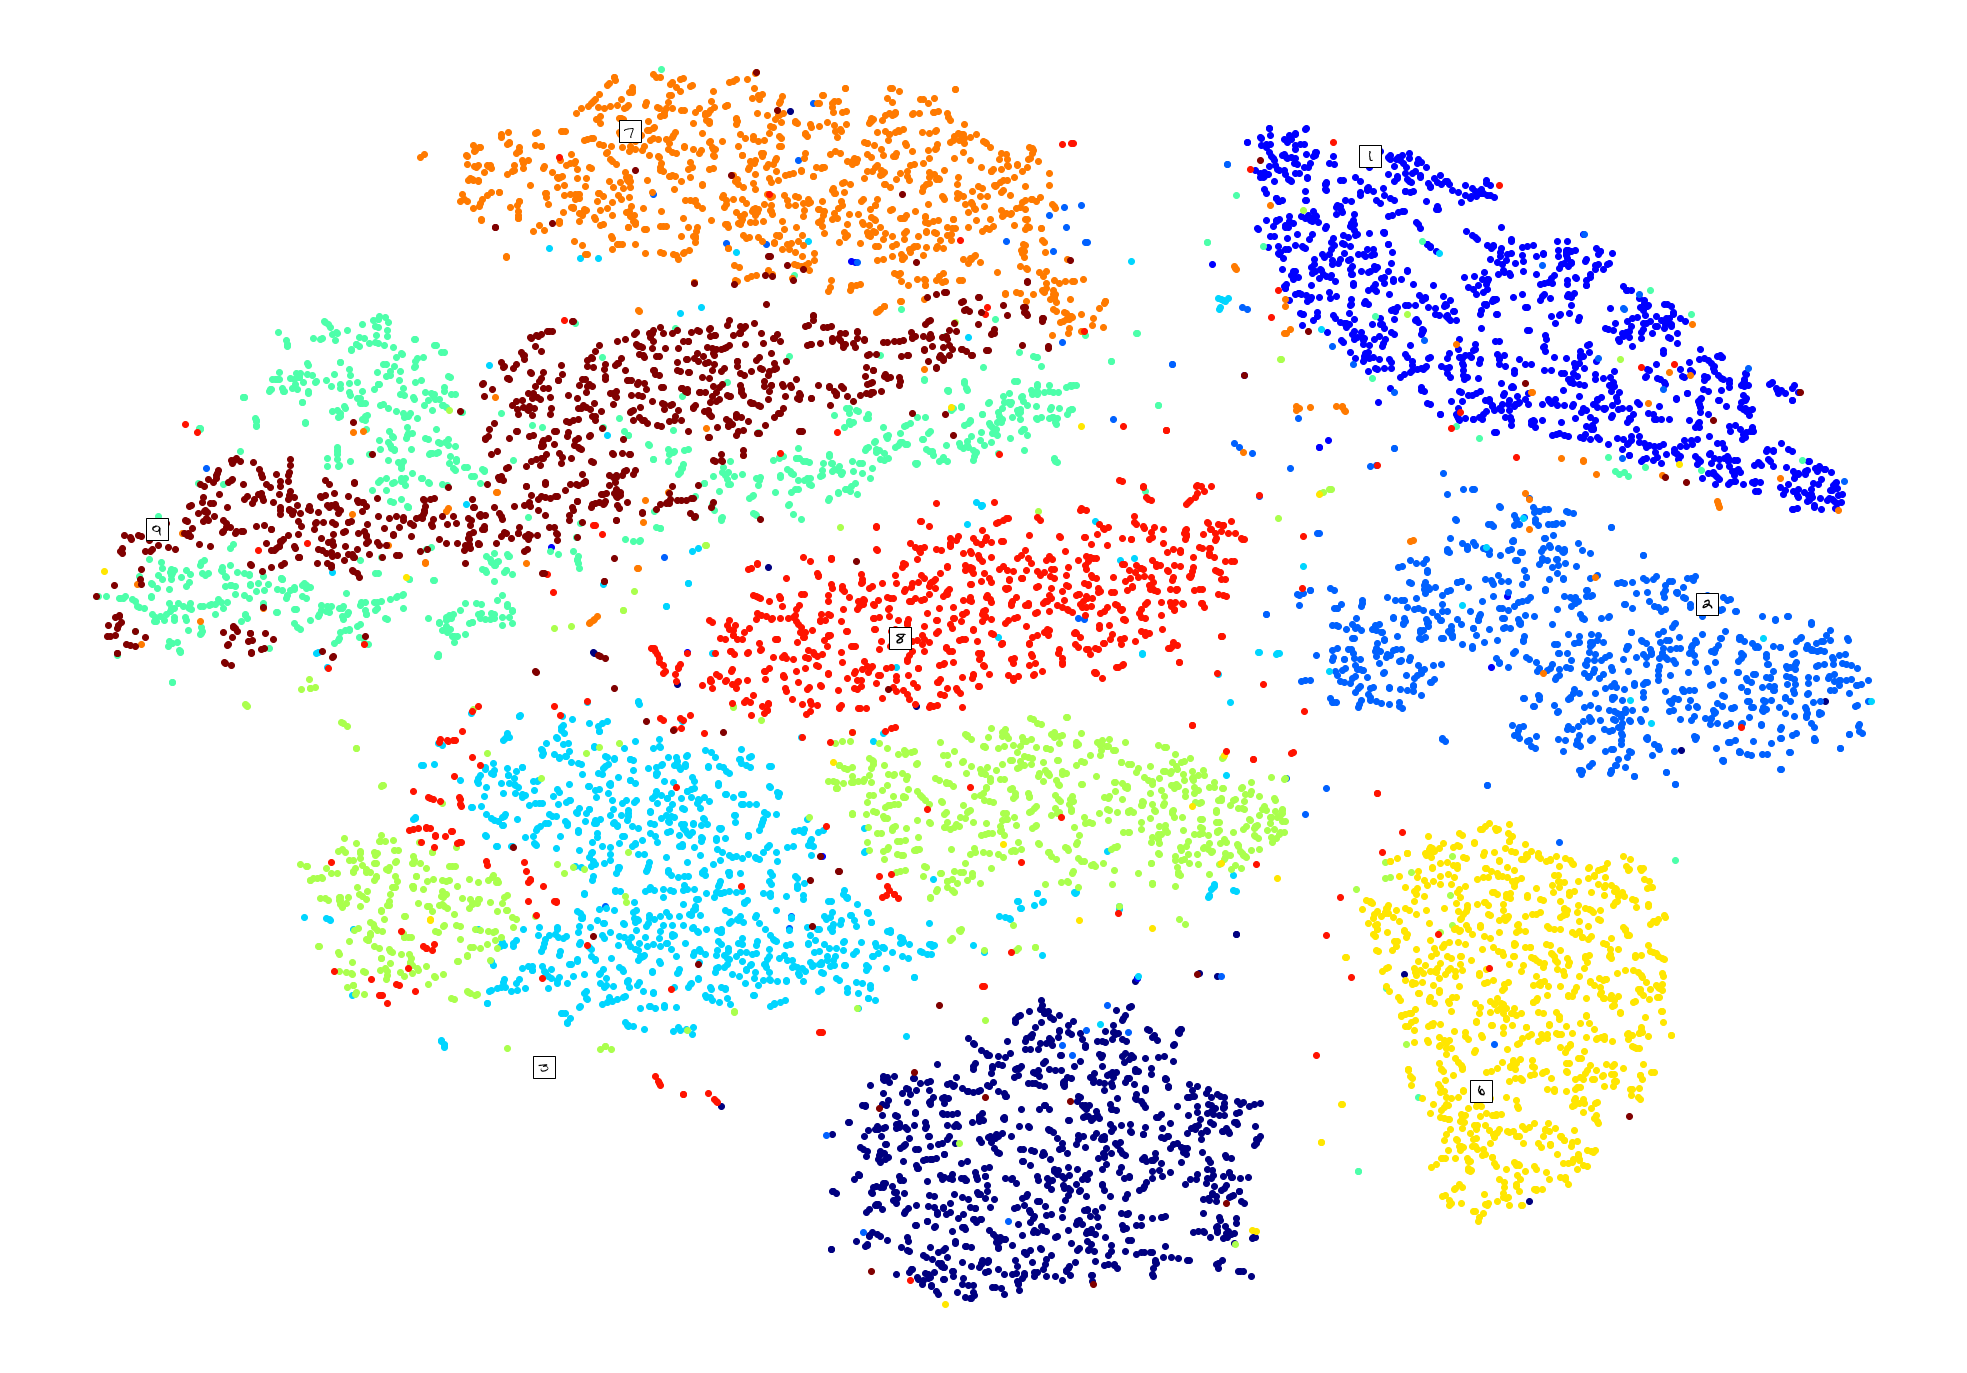

In [74]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25), min_distance=0.4)

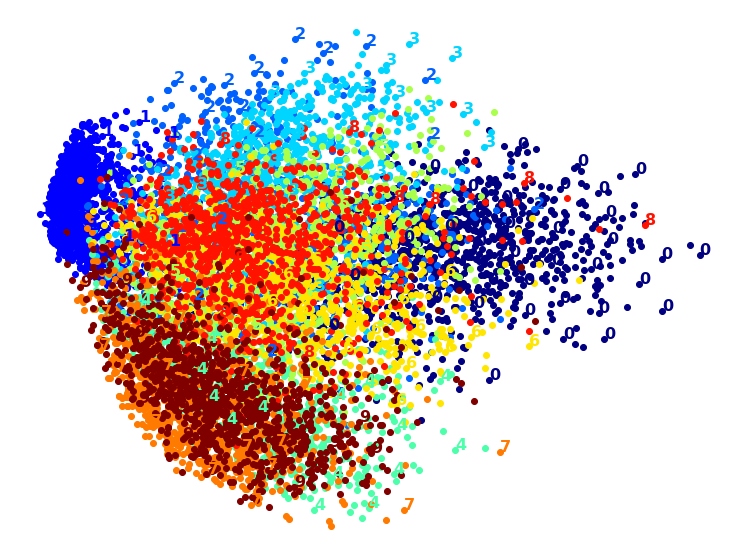

In [75]:
from sklearn.decomposition import PCA

X_pca_reduced = PCA(n_components=2).fit_transform(X)
plot_digits(X_pca_reduced, y)
plt.show()

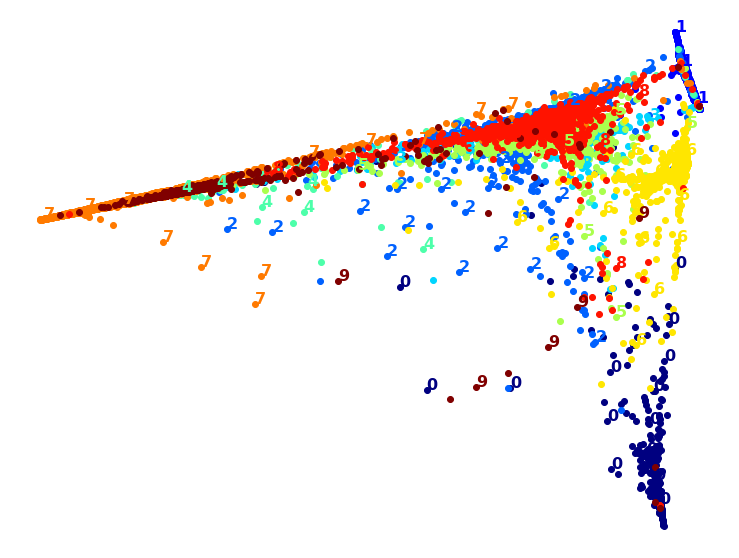

In [76]:
from sklearn.manifold import LocallyLinearEmbedding

X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
plot_digits(X_lle_reduced, y)
plt.show()

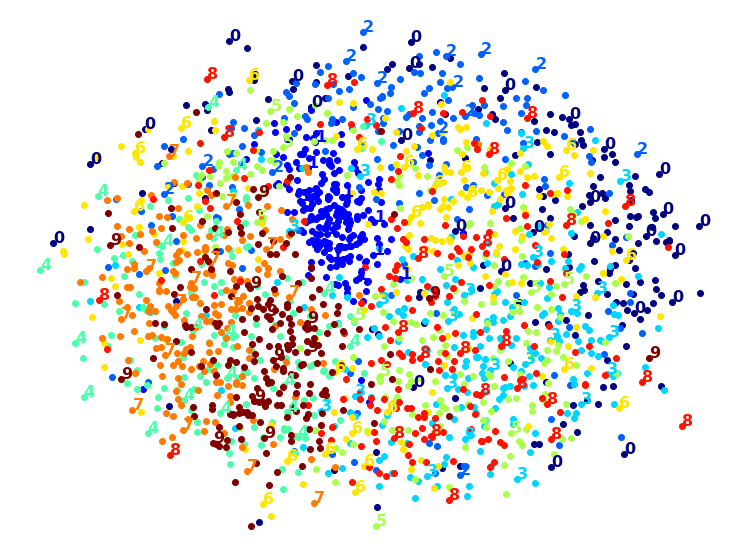

In [78]:
from sklearn.manifold import MDS
m=2000
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
plot_digits(X_mds_reduced, y[:m])
plt.show()

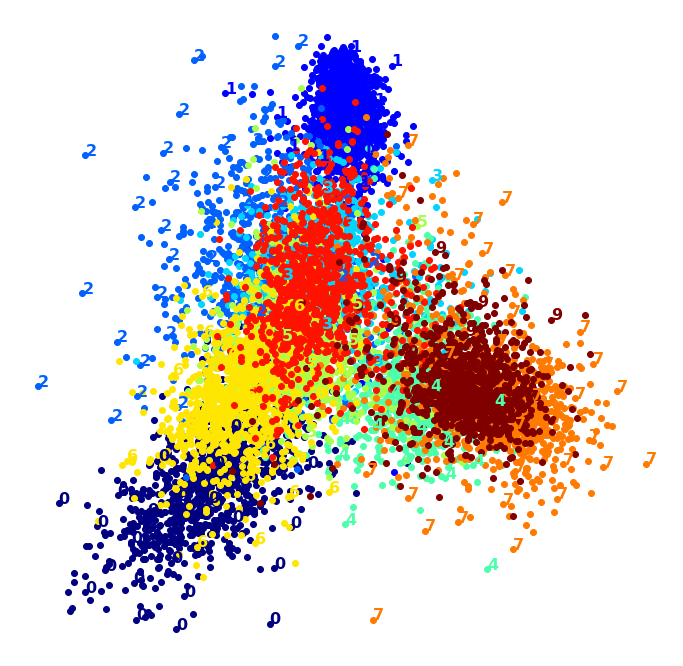

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
plot_digits(X_lda_reduced, y, figsize=(12, 12))
plt.show()